<a href="https://colab.research.google.com/github/ArtemJDS/EA-for-Feature-Selection/blob/main/fast_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [62]:
%%cython 

import numpy as np
cimport numpy as np
from cython.parallel import prange
import cv2
import cython
from libc.stdlib cimport rand, srand, RAND_MAX
from libc.math cimport sqrt
cdef extern from "limits.h":
    int INT_MAX
cdef extern from "math.h" :
    int lround(double x) nogil
from libc.stdlib cimport rand, srand, RAND_MAX
from libc.time cimport time
srand(time(NULL))

ctypedef fused numeric:
    double
    int

########################## USEFUL FUNCTIONS
@cython.boundscheck(False)
@cython.wraparound(False)
cdef numeric[:,:] twodim_genes_cleaner(numeric[:,:] genes,
                                       int position_ord_n,
                                       type T,
                                       int a):

    cdef Py_ssize_t i, j

    cdef int active_counter = 0
    cdef int length = genes.shape[0]
    cdef int width = genes.shape[1]

    cdef numeric[:,:] new_genes

    cdef int r

    if a == 0:

        for i in range(length):
            if (genes[i][position_ord_n] == 1 or genes[i][position_ord_n] == 0):
                active_counter = active_counter+1
        new_genes = np.empty((active_counter, width), dtype = T)

        r = 0
        for i in range(length):
            if genes[i][position_ord_n] == 1 or genes[i][position_ord_n] == 0:

                for j in prange(width, nogil = True):
                    new_genes[r][j] = genes[i][j]
                r = r+1

    if a == -1:

        for i in range(length):
            if genes[i][position_ord_n] != -1:
                active_counter = active_counter+1
        new_genes = np.empty((active_counter, width), dtype = T)

        r = 0
        for i in range(length):
            if genes[i][position_ord_n] != -1:

                for j in prange(width, nogil = True):
                    new_genes[r][j] = genes[i][j]
                r = r+1

    return new_genes



cdef numeric[:] onedim_genes_cleaner(numeric[:] genes,
                                     type T,
                                     int a):

    cdef Py_ssize_t i
    cdef int active_counter = 0
    cdef int length = genes.size

    cdef numeric[:] new_genes

    cdef int r
    if a == -1:

        for i in range(length):
            if genes[i] != -1:
                active_counter = active_counter+1
        new_genes = np.empty(active_counter, dtype = T)

        r = 0
        for i in range(length):
            if genes[i] != -1:
                new_genes[r] = genes[i]
                r = r+1

    if a == 0:

        for i in range(length):
            if genes[i] == 0 or genes[i] == 1:
                active_counter = active_counter+1
        new_genes = np.empty(active_counter, dtype = T)

        r = 0
        for i in range(length):
            if genes[i] == 0 or genes[i] == 1:
                new_genes[r] = genes[i]
                r = r+1
    return new_genes



@cython.boundscheck(False)
@cython.wraparound(False)
cdef int randint(int lower,
                 int upper) nogil:
    return (rand() % (upper-lower))


@cython.boundscheck(False)
@cython.wraparound(False)
cdef void change_gene_weigth(double[:] weights,
                             int index) nogil:

    # Helper function. Changes weight and limits it by 0.03 and 0.97
    # to left space for potentially useful mutations

    weights[index]  = (weights[index]+rand() / (RAND_MAX * 1.0)*(0.05-(-0.05))-0.05) * \
                      (0.03<weights[index]<0.97) + (0.97 * (weights[index]>0.97)) +\
                      (0.03 * (weights[index]<0.03))

cdef double sqroot( double x) nogil:
    return sqrt(x)

cdef int round( double x) nogil:
    return lround(x)







##########################  ACTIVATION FUNCTIONS
cdef extern from "math.h":
    double exp(double x) nogil

cdef inline double linear(double x) nogil:
    return x

cdef inline double logistic(double x) nogil:
    return 1/(1+exp(x))

cdef inline double tanh(double x) nogil:
    return 2/(1 + exp(-2*x)) - 1

cdef inline double ReLU(double x) nogil:
    return 0 * (x <= 0) + x * (x > 0)




##########################  NETWORK

cdef class Network:

    cdef readonly int network_order_number
    cdef readonly int first_parent
    cdef readonly int second_parent

    cdef readonly int [:,:] neurons_genes
    cdef readonly double [:] mutation_genes
    cdef readonly double [:,:] connections_genes
    cdef readonly double [:,:] matrix

    cdef public double efficiency
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void params_setter(self,
                            int order_number,
                            int [:,:] neurons_genes,
                            double [:] mutation_genes,
                            double [:,:] connections_genes,
                            double [:,:] matrix) nogil:

        self.network_order_number = order_number

        cdef Py_ssize_t i, j
        cdef int length, width

        with gil:
                length = neurons_genes.shape[0]
                width = neurons_genes.shape[1]

                self.neurons_genes = np.empty((length, width), dtype = np.int32 )
                self.mutation_genes = np.empty(length, dtype = np.float64 )

        for i in range(length):
            for j in range(width):
              self.neurons_genes[i][j] = neurons_genes[i][j]

            self.mutation_genes[i] = mutation_genes[i]

        with gil:
                length = connections_genes.shape[0]
                width = connections_genes.shape[1]
                self.connections_genes = np.empty((length, width), dtype = np.float64 )

        for i in range(length):
            for j in range(width):
              self.connections_genes[i][j] = connections_genes[i][j]

        with gil:
                length = matrix.shape[0]
                width = matrix.shape[1]
                self.matrix = np.empty((length, width), dtype = np.float64 )

        for i in range(length):
            for j in prange(width):
              self.matrix[i][j] = matrix[i][j]

        self.efficiency = 0.


########################## FACTORIES


cdef class Factory():

    cdef public int first_parent
    cdef public int second_parent

    cdef public int [:,:] neurons_genes
    cdef public double [:] mutation_genes
    cdef public double [:,:] connections_genes
    cdef public double [:,:] matrix
    '''
    Factory that returns networks.
    '''

cdef class GrandNetworkFactory_FullInput_NoInter(Factory):

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_neurons_genes(self,
                                   int number_of_neurons,
                                   int number_of_input_neurons,
                                   int number_of_output_neurons,
                                   int[:] activation_functions,
                                   double MUTATION_RATE):

        assert number_of_neurons >= number_of_input_neurons,'Number of input neurons\
        is larger or equal to number of all neurons'
        assert number_of_neurons >= number_of_output_neurons,'Number of output\
        neurons is larger or equal to number of all neurons'

        cdef Py_ssize_t i

        cdef int length_of_activation_f = activation_functions.size
        self.neurons_genes = np.empty((number_of_neurons, 4),
                                    dtype = np.int32 )
        self.mutation_genes = np.empty((number_of_neurons),
                                    dtype = np.float64)

        for i in prange(number_of_neurons, nogil=True):

            self.neurons_genes[i][0] = i

            # This part of code assigns neuron type to a particular neuron dependend
            # on its order number
            self.neurons_genes[i][1] = (0 * (i<number_of_input_neurons)
                                + 1 * (i >= number_of_input_neurons and
                                        i < number_of_neurons -
                                        number_of_output_neurons)
                                + 2 * (i >= number_of_input_neurons and
                                        i >= number_of_neurons -
                                        number_of_output_neurons))

            self.neurons_genes[i][2] = 0     # Since this is the 0'th iteration
            self.neurons_genes[i][3] = activation_functions[randint(0,length_of_activation_f)]

            self.mutation_genes[i] = MUTATION_RATE

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_connections_genes(self,
                                       int number_of_neurons,
                                       int number_of_input_neurons,
                                       int number_of_output_neurons,
                                       int[:] input_indexes,
                                       int[:] output_indexes,
                                       double WEIGHT,
                                       double MUTATION_RATE):

        cdef Py_ssize_t i

        self.connections_genes = np.empty((number_of_input_neurons+number_of_output_neurons, 6),
                                        dtype = np.float64)
        cdef int number_of_available_inputs = input_indexes.size
        cdef int number_of_available_outputs = output_indexes.size
        for i in prange(number_of_input_neurons, nogil = True):
            self.connections_genes[i][0] = input_indexes[randint(0, number_of_available_inputs)]

            #how input indexes are assigned to neurons. previously number of inputs should
            #have matched number of input neurons. Now they are assigned randomly

            self.connections_genes[i][1] = i/1.
            self.connections_genes[i][2] = WEIGHT
            self.connections_genes[i][3] = 1.
            self.connections_genes[i][4] = 0.                                   # Since this is the 0'th iteration
            self.connections_genes[i][5] = MUTATION_RATE

        for i in prange(number_of_output_neurons, nogil = True):
            self.connections_genes[i+number_of_input_neurons][0] = (i+number_of_neurons-number_of_output_neurons) /1.
            self.connections_genes[i+number_of_input_neurons][1] = output_indexes[randint(0, number_of_available_outputs)]
            self.connections_genes[i+number_of_input_neurons][2] = WEIGHT
            self.connections_genes[i+number_of_input_neurons][3] = 1.
            self.connections_genes[i+number_of_input_neurons][4] = 0.                                   # Since this is the 0'th iteration
            self.connections_genes[i+number_of_input_neurons][5] = MUTATION_RATE


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_matrix(self, int number_of_inputs):

        self.matrix = np.zeros((self.neurons_genes.shape[0], self.neurons_genes.shape[0]+\
                                number_of_inputs), dtype = np.float64)
        self.matrix = self.initialize_matrix(self.matrix,
                                             self.connections_genes,
                                             number_of_inputs)

    cdef Network get_network(self, int order_number):

        cdef Network A
        A = Network()
        A.params_setter(order_number,
                        self.neurons_genes,
                        self.mutation_genes,
                        self.connections_genes,
                        self.matrix)
        return A

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double [:,:]  initialize_matrix(self,
                                         double [:,:] matrix,
                                         double [:,:] connections_genes,
                                         int number_of_inputs ) nogil :

        cdef Py_ssize_t i
        cdef int from_
        cdef int to_
        cdef int input_index
        cdef int length

        with gil: length = connections_genes.shape[0]

        for i in range(length):
            if connections_genes[i][3]==1 and connections_genes[i][1] >= 0: # checks activity status of a connection and whether it's not an output connection

                # if it is input -> input neuron connection
                if connections_genes[i][0]<0:

                    with gil:
                    # since numeration starts with -1
                        from_ = abs(int(connections_genes[i][0]))-1
                        to_ = int(connections_genes[i][1])

                    matrix[to_][from_] = connections_genes[i][2]

                # if it is neuron -> neuron connection
                elif connections_genes[i][0]>=0:

                    with gil:
                        from_ = int(connections_genes[i][0]) + number_of_inputs     # Since there are inputs before neurons in every row
                        to_ = int(connections_genes[i][1])

                    matrix[to_][from_] = connections_genes[i][2]
        return matrix


cdef class NetworkFactory(Factory):
    
    cdef public int [:,:] matches
    cdef public int [:,:] created_neurons_genes
    cdef public double [:] created_mutation_genes
    cdef public double [:,:] created_connections_genes
    cdef public dict second_matches

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_neurons_genes_through_mating(self,
                                                  Network parent_1,
                                                  Network parent_2):

        cdef Py_ssize_t i, j

        cdef int length_parent_1 = parent_1.neurons_genes.shape[0]
        cdef int length_parent_2 = parent_2.neurons_genes.shape[0]
        cdef int width = parent_1.neurons_genes.shape[1]

        self.first_parent = parent_1.network_order_number
        self.second_parent = parent_2.network_order_number

        cdef int number_of_neurons_in_parents = length_parent_1+length_parent_2
        cdef int the_longest_one, the_shortes_one, longer_index

        cdef double R = rand() / (RAND_MAX * 1.0)
        cdef int number_of_neurons_in_child

        if length_parent_1>=length_parent_2:
            the_longest_one = length_parent_1
            the_smallest_one = length_parent_2
            longer_index = 1

        else:
            the_longest_one = length_parent_2
            the_smallest_one = length_parent_1
            longer_index = 2


        if number_of_neurons_in_parents%2 == 0:
            number_of_neurons_in_child = number_of_neurons_in_parents//2\
                                                + randint(0,3) - 1

        else:
            number_of_neurons_in_child = (number_of_neurons_in_parents+\
                                        1*(R >= 0.5) - 1*(R < 0.5))//2 \
                                        + randint(0,3)-1


        self.created_neurons_genes = np.empty((number_of_neurons_in_child, 4),
                                    dtype = np.int32)
        self.matches = np.empty((number_of_neurons_in_child,4),
                                    dtype = np.int32)
        self.created_mutation_genes = np.empty((number_of_neurons_in_child),
                                    dtype = np.float64)

        for i in prange(number_of_neurons_in_child, nogil=True):

            self.matches[i][0] = randint(0, the_longest_one)      # old neuron || 1/2 parent || new neuron || used status, its index ([i]) must be identical to 'new neuron'
            self.matches[i][2] = i
            self.matches[i][3] = 0

            if self.matches[i][0]<the_smallest_one:

                if rand() / (RAND_MAX * 1.0) <0.5:

                    self.matches[i][1] = 1
                    for j in prange(width):

                        if j == 0:
                            self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_1.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_1.mutation_genes[self.matches[i][0]]

                else:

                    self.matches[i][1] = 2
                    for j in prange(width):

                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_2.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_2.mutation_genes[self.matches[i][0]]


            elif self.matches[i][0]>=the_smallest_one:

                self.matches[i][1] = longer_index

                if longer_index == 1:

                    for j in prange(width):
                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_1.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_1.mutation_genes[self.matches[i][0]]

                elif longer_index == 2:

                    for j in prange(width):
                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_2.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_2.mutation_genes[self.matches[i][0]]
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_connections_genes_through_mating(self,
                                                      Network parent_1,
                                                      Network parent_2):

        cdef Py_ssize_t i, j, k, l

        cdef int length_parent_1 = parent_1.connections_genes.shape[0]
        cdef int length_parent_2 = parent_2.connections_genes.shape[0]
        cdef int width = parent_1.connections_genes.shape[1]

        cdef int neurons_length_parent_1 = parent_1.neurons_genes.shape[0]
        cdef int neurons_length_parent_2 = parent_2.neurons_genes.shape[0]

        cdef int longer_connections_genome
        if length_parent_1 >= length_parent_2:
            longer_connections_genome = length_parent_1
        else:
            longer_connections_genome = length_parent_2

        cdef int length_of_matches = self.matches.shape[0]
        cdef int index_of_new_neuron_in_matches
        cdef int index_of_old_neuron

        cdef double[:,:] long_connections_genes = np.empty(((longer_connections_genome+1)*length_of_matches, width), dtype=np.float64)

        for i in prange((longer_connections_genome+1)*length_of_matches, nogil = True):
            long_connections_genes[i][3] =-1.

        for i in prange(length_of_matches, nogil = True):

            index_of_new_neuron_in_matches = self.created_neurons_genes[i][0]
            if self.matches[index_of_new_neuron_in_matches][1] == 1:

                index_of_old_neuron = self.matches[index_of_new_neuron_in_matches][0]

                for j in prange(length_parent_1):

                    if parent_1.connections_genes[j][3] != -1.:

                        if parent_1.connections_genes[j][0] == index_of_old_neuron:

                            if parent_1.connections_genes[j][1] >= 0:
                                for k in prange(length_of_matches):

                                    if self.matches[k][0] == parent_1.connections_genes[j][1] and self.matches[k][3] != 1 :
                                        if self.matches[k][1] == 1:

                                            long_connections_genes[i *(longer_connections_genome+1) + j][0] = index_of_new_neuron_in_matches/1.
                                            long_connections_genes[i *(longer_connections_genome+1) + j][1] = self.matches[k][2]/1.
                                            long_connections_genes[i *(longer_connections_genome+1) + j][2] = parent_1.connections_genes[j][2]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][3] = parent_1.connections_genes[j][3]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][4] = parent_1.connections_genes[j][4]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][5] = parent_1.connections_genes[j][5]

                                            self.matches[k][3] = 1


                            if parent_1.connections_genes[j][1] < 0 :
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][0] = index_of_new_neuron_in_matches/1.
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][1] = parent_1.connections_genes[j][1]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][2] = parent_1.connections_genes[j][2]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][3] = parent_1.connections_genes[j][3]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][4] = parent_1.connections_genes[j][4]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][5] = parent_1.connections_genes[j][5]



                        if parent_1.connections_genes[j][0] < 0 and parent_1.connections_genes[j][1] == index_of_old_neuron:
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][0] = parent_1.connections_genes[j][0]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][1] = index_of_new_neuron_in_matches/1.
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][2] = parent_1.connections_genes[j][2]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][3] = parent_1.connections_genes[j][3]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][4] = parent_1.connections_genes[j][4]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][5] = parent_1.connections_genes[j][5]

            elif self.matches[index_of_new_neuron_in_matches][1] == 2:

                index_of_old_neuron = self.matches[index_of_new_neuron_in_matches][0]

                for j in prange(length_parent_2):

                    if parent_2.connections_genes[j][3] != -1.:

                        if parent_2.connections_genes[j][0] == index_of_old_neuron:

                            if parent_2.connections_genes[j][1] >= 0:
                                for k in prange(length_of_matches):

                                    if self.matches[k][0] == parent_2.connections_genes[j][1] and self.matches[k][3] != 1 :
                                        if self.matches[k][1] == 2:

                                            long_connections_genes[i *(longer_connections_genome+1) + j][0] = index_of_new_neuron_in_matches/1.
                                            long_connections_genes[i *(longer_connections_genome+1) + j][1] = self.matches[k][2]/1.
                                            long_connections_genes[i *(longer_connections_genome+1) + j][2] = parent_2.connections_genes[j][2]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][3] = parent_2.connections_genes[j][3]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][4] = parent_2.connections_genes[j][4]
                                            long_connections_genes[i *(longer_connections_genome+1) + j][5] = parent_2.connections_genes[j][5]

                                            self.matches[k][3] = 1

                            elif parent_2.connections_genes[j][1] < 0:
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][0] = index_of_new_neuron_in_matches/1.
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][1] = parent_2.connections_genes[j][1]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][2] = parent_2.connections_genes[j][2]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][3] = parent_2.connections_genes[j][3]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][4] = parent_2.connections_genes[j][4]
                                long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][5] = parent_2.connections_genes[j][5]

                        if parent_2.connections_genes[j][0] < 0 and parent_2.connections_genes[j][1] == index_of_old_neuron:
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][0] = parent_2.connections_genes[j][0]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][1] = index_of_new_neuron_in_matches/1.
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][2] = parent_2.connections_genes[j][2]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][3] = parent_2.connections_genes[j][3]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][4] = parent_2.connections_genes[j][4]
                            long_connections_genes[i *(longer_connections_genome+1) + longer_connections_genome][5] = parent_2.connections_genes[j][5]

            for k in prange(length_of_matches):
                self.matches[k][3] = 0

        self.created_connections_genes = twodim_genes_cleaner(long_connections_genes,
                                                                 3,
                                                                 np.float64,
                                                                 0)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void mutate_neurons_genes(self,
                                   double prb_deleteion,
                                   int [:] activation_functions,
                                   int [:] input_indexes,
                                   int [:] output_indexes,
                                   int iteration,
                                   double WEIGHT,
                                   double MUTATION):

        cdef Py_ssize_t i
        cdef int length_of_neurons_genes = self.created_neurons_genes.shape[0]
        cdef int width_of_neurons_genes = self.created_neurons_genes.shape[1]

        cdef int length_of_activation_f = activation_functions.size

        cdef int neurons_to_be_added = int(prb_deleteion * length_of_neurons_genes) + 1 *(0 >= int(prb_deleteion * length_of_neurons_genes))

        for i in prange(length_of_neurons_genes, nogil = True):

            if prb_deleteion >= rand() / (RAND_MAX * 1.0):

                with gil:
                    self.created_neurons_genes, self.created_connections_genes,  self.created_mutation_genes = \
                    self.delete_neuron(self.created_neurons_genes,
                                       self.created_mutation_genes,
                                       self.created_connections_genes,
                                       i,
                                       i)
            else:
                if self.created_mutation_genes[i] >= rand() / (RAND_MAX * 1.0):
                    self.created_neurons_genes[i][3] = activation_functions[randint(0,length_of_activation_f)]

                if self.created_mutation_genes[i] >= rand() / (RAND_MAX * 1.0):
                    change_gene_weigth(self.created_mutation_genes, i)


        self.neurons_genes = np.empty((length_of_neurons_genes+neurons_to_be_added, width_of_neurons_genes), dtype = np.int32)

        self.mutation_genes = np.empty((length_of_neurons_genes+neurons_to_be_added), dtype = np.float64)

        self.neurons_genes, self.mutation_genes,self.connections_genes = \
                                self.add_neurons(self.neurons_genes,
                                                 self.created_neurons_genes,
                                                 self.mutation_genes,
                                                 self.created_mutation_genes,
                                                 self.created_connections_genes,
                                                 neurons_to_be_added,
                                                 input_indexes,
                                                 output_indexes,
                                                 iteration,
                                                 activation_functions,
                                                 WEIGHT,
                                                 MUTATION)

        self.mutation_genes = onedim_genes_cleaner(self.mutation_genes,
                                                      np.float64,
                                                      -1)
        self.neurons_genes = twodim_genes_cleaner(self.neurons_genes,
                                                     0,
                                                     np.int32,
                                                     -1)



    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void mutate_connections_genes(self,
                                       double prb_deleteion,
                                       int iteration):

        cdef Py_ssize_t i, j
        cdef int length_of_connections_genes = self.connections_genes.shape[0]
        cdef int width_of_connections_genes=  self.connections_genes.shape[1]
        cdef int number_of_connections_to_be_added  = int(prb_deleteion * length_of_connections_genes) + 1 *(0 >= int(prb_deleteion * length_of_connections_genes))

        for i in range(length_of_connections_genes):

            if self.connections_genes[i][3] != -1.:

                if prb_deleteion >= rand() / (RAND_MAX * 1.0) and (self.connections_genes[i][0] >= 0 and self.connections_genes[i][1] >= 0):
                    # extra check added to prevent input and ouput connections from deletion
                    for j in prange(width_of_connections_genes, nogil = True):
                        self.connections_genes[i][j] = -1.

                    continue
                else:
                    if self.connections_genes[i][5] >= rand() / (RAND_MAX * 1.0):
                        self.connection_change(self.neurons_genes,
                                          self.connections_genes,
                                          i)


                    if self.connections_genes[i][5] >= rand() / (RAND_MAX * 1.0):
                        change_gene_weigth(self.connections_genes[i], 5)
        self.connections_genes = self.add_connection(self.neurons_genes,
                                                     self.connections_genes,
                                                     number_of_connections_to_be_added,
                                                     iteration)
        self.connections_genes = twodim_genes_cleaner(self.connections_genes,
                                                      3,
                                                      np.float64,
                                                      -1)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_matrix(self, int number_of_inputs):

        self.connections_genes = self.check_for_dublication()
        self.matrix = np.zeros((self.neurons_genes.shape[0], self.neurons_genes.shape[0]+\
                                number_of_inputs), dtype = np.float64)
        cdef Py_ssize_t i
        cdef int neurons_genes_length = self.neurons_genes.shape[0]
        cdef int connections_genes_length = self.connections_genes.shape[0]
        self.second_matches = {}

        for i in range(neurons_genes_length):
            self.second_matches[self.neurons_genes[i][0]] = i
            self.neurons_genes[i][0] = i

        for i in range(connections_genes_length):
            if self.connections_genes[i][0] >= 0:
                self.connections_genes[i][0] = self.second_matches[self.connections_genes[i][0]]/1.
            if self.connections_genes[i][1] >= 0:
                self.connections_genes[i][1] = self.second_matches[self.connections_genes[i][1]]/1.
        self.matrix = self.initialize_matrix(self.matrix,
                                             self.connections_genes,
                                             number_of_inputs)

    cdef Network get_network(self, int order_number):

        cdef Network A
        A = Network()
        A.params_setter(order_number,
                        self.neurons_genes,
                        self.mutation_genes,
                        self.connections_genes,
                        self.matrix)
        return A


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef delete_neuron(self,
                       int [:,:] neurons_genes,
                       double [:] mutation_genes,
                       double [:,:]  connections_genes,
                       int order_number_delete,
                       int order_number_connection):

       cdef Py_ssize_t i, j

       cdef int neurons_genes_length = neurons_genes.shape[0]
       cdef int neurons_genes_width = neurons_genes.shape[1]

       cdef int connections_genes_length = connections_genes.shape[0]
       cdef int connections_genes_width = connections_genes.shape[1]

       cdef int mutation_genes_length = mutation_genes.shape[0]

       for j in prange(neurons_genes_width, nogil = True):
          neurons_genes[order_number_delete][j] = -1
       mutation_genes[order_number_delete] = -1.


       for i in prange(connections_genes_length, nogil=True):
           if connections_genes[i][0] == order_number_connection or connections_genes[i][1] == order_number_connection:

               for j in prange(connections_genes_width):
                    connections_genes[i][j] = -1.

       return  neurons_genes, connections_genes, mutation_genes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double [:,:]  initialize_matrix(self,
                                        double [:,:] matrix,
                                        double [:,:] connections_genes,
                                        int number_of_inputs ) nogil :

       cdef Py_ssize_t i
       cdef int from_
       cdef int to_
       cdef int input_index
       cdef int length

       with gil: length = connections_genes.shape[0]

       for i in range(length):
           if connections_genes[i][3]==1 and connections_genes[i][1] >= 0: # checks activity status of a connection and whether it's not an output connection

               # if it is input -> input neuron connection
               if connections_genes[i][0]<0:

                   with gil:
                   # since numeration starts with -1
                       from_ = abs(int(connections_genes[i][0]))-1
                       to_ = int(connections_genes[i][1])

                   matrix[to_][from_] = connections_genes[i][2]

               # if it is neuron -> neuron connection
               elif connections_genes[i][0]>=0:

                   with gil:
                       from_ = int(connections_genes[i][0]) + number_of_inputs     # Since there are inputs before neurons in every row
                       to_ = int(connections_genes[i][1])

                   matrix[to_][from_] = connections_genes[i][2]
       return matrix


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef add_neurons(self,
                     int[:,:] neurons_genes,
                     int[:,:] pre_mutation_neurons_genes,
                     double[:] mutation_genes,
                     double[:] pre_mutation_mutation_genes,
                     double[:, :] pre_mutation_connections_genes,
                     int neurons_to_add,
                     int[:] input_indexes,
                     int[:] output_indexes,
                     int iteration,
                     int[:] activation_functions,
                     double weight,
                     double mutation_rate):

       # All types of neurons may be added (0,1,2)

       cdef Py_ssize_t i, j

       cdef int old_neurons_length = pre_mutation_neurons_genes.shape[0]
       cdef int neurons_width = pre_mutation_neurons_genes.shape[1]

       cdef int last_ord_number = 0
       for i in range(old_neurons_length):
           if pre_mutation_neurons_genes[i][0] > last_ord_number:
               last_ord_number = pre_mutation_neurons_genes[i][0]

       cdef int old_connections_length = pre_mutation_connections_genes.shape[0]
       cdef int connections_width = pre_mutation_connections_genes.shape[1]

       cdef int length_of_activation_f = activation_functions.size

       cdef int[:] types_of_added_neurons = np.empty(neurons_to_add, dtype = np.int32)
       cdef int input_neurons_counter = 0
       cdef int output_neurons_counter = 0

       for i in prange(neurons_to_add, nogil = True):
           types_of_added_neurons[i] = randint(0,3)   # Here type of added neurons may be changed e.g. randint(1,3)

       for i in range(neurons_to_add):
           if types_of_added_neurons[i] == 0:
               input_neurons_counter += 1
           if types_of_added_neurons[i] == 2:
               output_neurons_counter += 1

       for i in prange(old_neurons_length, nogil = True):
           for j in prange(neurons_width):
               neurons_genes[i][j] = pre_mutation_neurons_genes[i][j]
           mutation_genes[i] = pre_mutation_mutation_genes[i]


       cdef double [:,:] connections_genes = np.empty((old_connections_length+input_neurons_counter+output_neurons_counter, connections_width), dtype = np.float64)

       for i in prange(old_connections_length, nogil = True):
           for j in prange(connections_width):
               connections_genes[i][j] = pre_mutation_connections_genes[i][j]

       cdef int counter = 0
       cdef int number_of_available_inputs = input_indexes.size
       cdef int number_of_available_outputs = output_indexes.size
       for i in range(neurons_to_add):
           neurons_genes[i+old_neurons_length][0] = i+last_ord_number+1
           neurons_genes[i+old_neurons_length][1] = types_of_added_neurons[i]
           neurons_genes[i+old_neurons_length][2] = iteration
           neurons_genes[i+old_neurons_length][3] = activation_functions[randint(0,length_of_activation_f)]
           mutation_genes[i+old_neurons_length] = weight

           if types_of_added_neurons[i] == 0:

               connections_genes[counter+old_connections_length][0] = input_indexes[randint(0,number_of_available_inputs)]/1.
               connections_genes[counter+old_connections_length][1] = neurons_genes[i+old_neurons_length][0]/1.
               connections_genes[counter+old_connections_length][2] = weight
               connections_genes[counter+old_connections_length][3] = 1.
               connections_genes[counter+old_connections_length][4] = iteration/1.
               connections_genes[counter+old_connections_length][5] = mutation_rate

               counter += 1

           if types_of_added_neurons[i] == 2:
               connections_genes[counter+old_connections_length][0] = neurons_genes[i+old_neurons_length][0]/1.
               connections_genes[counter+old_connections_length][1] = output_indexes[randint(0, number_of_available_outputs)]/1.
               connections_genes[counter+old_connections_length][2] = weight
               connections_genes[counter+old_connections_length][3] = 1.
               connections_genes[counter+old_connections_length][4] = iteration/1.
               connections_genes[counter+old_connections_length][5] = mutation_rate

               counter += 1

       return neurons_genes, mutation_genes, connections_genes



    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void connection_change(self,
                                int [:,:] neurons_genes,
                                double [:,:] connections_genes,
                                int order_number):

       cdef Py_ssize_t i,j

       cdef int length = neurons_genes.shape[0]
       cdef int width = neurons_genes.shape[1]
       cdef int what_parameter_is_changed = randint(0, width)

       cdef int random_neuron = neurons_genes[randint(0, length)][0]

       if what_parameter_is_changed == 0:

           if connections_genes[order_number][0] >= 0 and connections_genes[order_number][1] >= 0:
               connections_genes[order_number][what_parameter_is_changed] = \
                                               random_neuron /1.


       elif what_parameter_is_changed == 1:

           if connections_genes[order_number][1] >= 0 and connections_genes[order_number][0] >= 0:
               connections_genes[order_number][what_parameter_is_changed] = \
                                               random_neuron /1.

       elif what_parameter_is_changed == 2:

           change_gene_weigth(connections_genes[order_number], what_parameter_is_changed)

       elif what_parameter_is_changed == 3:

           if connections_genes[order_number][what_parameter_is_changed] == 0.:
               connections_genes[order_number][what_parameter_is_changed] = 1.

           else:
               connections_genes[order_number][what_parameter_is_changed] = 0.

       # other parameters cannot be changed due to their 'nature'

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double[:,:] add_connection(self,
                                    int [:,:] neurons_genes,
                                    double[:,:] connections_genes,
                                    int number_of_connections_to_be_added,
                                    int iteration):

       cdef Py_ssize_t i, j
       cdef int connections_genes_length = connections_genes.shape[0]
       cdef int connections_genes_width = connections_genes.shape[1]

       cdef int neurons_genes_length = neurons_genes.shape[0]

       cdef double[:,:] new_connections_genes
       cdef double mean_weight = 0.
       cdef double mean_mutation_rate = 0.

       new_connections_genes = \
                      np.empty((connections_genes_length+number_of_connections_to_be_added, connections_genes_width), dtype = np.float64)

       for i in prange(connections_genes_length, nogil = True):

           for j in prange(connections_genes_width):
               new_connections_genes[i][j] = connections_genes[i][j]

       for i in range(connections_genes_length):

           if new_connections_genes[i][3] != -1:
               mean_weight = mean_weight+new_connections_genes[i][2]/connections_genes_length
               mean_mutation_rate = mean_mutation_rate + new_connections_genes[i][5]/connections_genes_length

       for i in prange(number_of_connections_to_be_added, nogil = True):
           new_connections_genes[i+connections_genes_length][0] = neurons_genes[randint(0, neurons_genes_length)][0]/1.
           new_connections_genes[i+connections_genes_length][1] = neurons_genes[randint(0, neurons_genes_length)][0]/1.
           new_connections_genes[i+connections_genes_length][2] = mean_weight
           new_connections_genes[i+connections_genes_length][3] = 1.       # Neurons are added in active state
           new_connections_genes[i+connections_genes_length][4] = iteration/1.
           new_connections_genes[i+connections_genes_length][5] = mean_mutation_rate


       return new_connections_genes
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double[:,:]  check_for_dublication(self):
        cdef Py_ssize_t i, j
        cdef int length = self.connections_genes.shape[0]
        cdef int width = self.connections_genes.shape[1]
        cdef double first, second
        cdef int[:] to_delete = np.zeros(length, dtype = np.int32)
        cdef int deleted = 0

        for i in range(length):
            if to_delete[i]!=1:
                first = self.connections_genes[i][0]
                second = self.connections_genes[i][1]
                for j in range(i+1, length):
                        if first == self.connections_genes[j][0] and second == self.connections_genes[j][1] and to_delete[j]!=1 :
                            to_delete[j] = 1
                            deleted += 1


        cdef double[:, :]  connections_genes = np.empty(((length - deleted), width), dtype = np.float64)
        cdef int counter = 0


        for i in range(length):
            if to_delete[i] != 1:
                for j in prange(width, nogil = True):
                    connections_genes[i-counter][j] = self.connections_genes[i][j]

            else:
                counter += 1

        return connections_genes

cdef class NetworkFactoryFair(NetworkFactory):

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_neurons_genes_through_mating(self,
                                                  Network parent_1,
                                                  Network parent_2):
        # The methods differs from the parent's in relation to the probabilities
        # of getting neurons from parents. Here the more efficient parent has
        # advantage (greater probability of transmitting genes forward)

        cdef Py_ssize_t i, j

        cdef int length_parent_1 = parent_1.neurons_genes.shape[0]
        cdef int length_parent_2 = parent_2.neurons_genes.shape[0]
        cdef int width = parent_1.neurons_genes.shape[1]

        self.first_parent = parent_1.network_order_number
        self.second_parent = parent_2.network_order_number

        cdef int number_of_neurons_in_parents = length_parent_1+length_parent_2
        cdef int the_longest_one, the_shortes_one, longer_index

        cdef double R = rand() / (RAND_MAX * 1.0)
        cdef int number_of_neurons_in_child

        if length_parent_1>=length_parent_2:
            the_longest_one = length_parent_1
            the_smallest_one = length_parent_2
            longer_index = 1

        else:
            the_longest_one = length_parent_2
            the_smallest_one = length_parent_1
            longer_index = 2


        if number_of_neurons_in_parents%2 == 0:
            number_of_neurons_in_child = number_of_neurons_in_parents//2\
                                                + randint(0,3) - 1

        else:
            number_of_neurons_in_child = (number_of_neurons_in_parents+\
                                        1*(R >= 0.5) - 1*(R < 0.5))//2 \
                                        + randint(0,3)-1


        self.created_neurons_genes = np.empty((number_of_neurons_in_child, 4),
                                    dtype = np.int32)
        self.matches = np.empty((number_of_neurons_in_child,4),
                                    dtype = np.int32)
        self.created_mutation_genes = np.empty((number_of_neurons_in_child),
                                    dtype = np.float64)

        cdef double efficiency_sum = parent_1.efficiency +parent_2.efficiency

        for i in prange(number_of_neurons_in_child, nogil=True):

            self.matches[i][0] = randint(0, the_longest_one)      # old neuron || 1/2 parent || new neuron || used status, its index ([i]) must be identical to 'new neuron'
            self.matches[i][2] = i
            self.matches[i][3] = 0

            if self.matches[i][0]<the_smallest_one:

                if rand() / (RAND_MAX * 1.0) < parent_1.efficiency/efficiency_sum:     # here is the difference

                    self.matches[i][1] = 1
                    for j in prange(width):

                        if j == 0:
                            self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_1.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_1.mutation_genes[self.matches[i][0]]

                else:

                    self.matches[i][1] = 2
                    for j in prange(width):

                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_2.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_2.mutation_genes[self.matches[i][0]]


            elif self.matches[i][0]>=the_smallest_one:

                self.matches[i][1] = longer_index

                if longer_index == 1:

                    for j in prange(width):
                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_1.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_1.mutation_genes[self.matches[i][0]]

                elif longer_index == 2:

                    for j in prange(width):
                        if j == 0:
                           self.created_neurons_genes[i][j] = i
                        else:
                            self.created_neurons_genes[i][j] = parent_2.neurons_genes[self.matches[i][0]][j]

                    self.created_mutation_genes[i] = parent_2.mutation_genes[self.matches[i][0]]


########################## CROSSOVER

class Exctinction(Exception):
    pass

cdef class Mating:

    cdef double limit
    cdef double neuron_prb_del
    cdef double connection_prb_del
    cdef int[:] activation_functions
    cdef int number_of_inputs
    cdef int iteration
    cdef double weight
    cdef double mutation_rate
    cdef int[:] input_indexes
    cdef int[:] output_indexes
    cdef int init_order_number

    cdef void set_efficiency_limit(self, double limit):
        self.limit = limit

    cdef void set_neuron_prb_del(self, double neuron_prb_del):
        self.neuron_prb_del = neuron_prb_del

    cdef void set_connection_prb_del(self, double connection_prb_del):
        self.connection_prb_del = connection_prb_del

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_activation_functions(self, int[:] activation_functions):

        cdef Py_ssize_t i
        cdef int length = activation_functions.size
        self.activation_functions = np.empty(length, dtype = np.int32)

        for i in prange(length, nogil = True):
            self.activation_functions[i] = activation_functions[i]

    cdef void set_number_of_inputs(self, int number_of_inputs):
        self.number_of_inputs = number_of_inputs

    cdef void set_iteration(self, int iteration):
        self.iteration = iteration

    cdef void set_default_weigth(self, double weight):
        self.weight = weight

    cdef void set_mutation_rate(self, double mutation_rate):
        self.mutation_rate = mutation_rate

    cdef void set_order_number(self, int init_order_number):
        self.init_order_number = init_order_number

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_input_indexes(self, int[:] input_indexes):

        cdef Py_ssize_t i
        cdef int length = input_indexes.size
        self.input_indexes = np.empty(length, dtype = np.int32)

        for i in prange(length, nogil = True):
            self.input_indexes[i] = input_indexes[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_output_indexes(self, int[:] output_indexes):

        cdef Py_ssize_t i
        cdef int length = output_indexes.size
        self.output_indexes = np.empty(length, dtype = np.int32)

        for i in prange(length, nogil = True):
            self.output_indexes[i] = output_indexes[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_mutation_params(self,
                                  double neuron_prb_del,
                                  double connection_prb_del,
                                  int[:] activation_functions,
                                  int number_of_inputs,
                                  int iteration,
                                  int init_order_number,
                                  int [:] input_indexes,
                                  int [:] output_indexes,
                                  double WEIGHT,
                                  double MUTATION_RATE):

        self.neuron_prb_del = neuron_prb_del
        self.connection_prb_del = connection_prb_del

        cdef Py_ssize_t i

        cdef int length = activation_functions.size
        self.activation_functions = np.empty(length, dtype = np.int32)
        for i in prange(length, nogil = True):
            self.activation_functions[i] = activation_functions[i]

        self.number_of_inputs = number_of_inputs
        self.iteration = iteration
        self.init_order_number = init_order_number
        self.weight = WEIGHT
        self.mutation_rate = MUTATION_RATE

        length = input_indexes.size
        self.input_indexes = np.empty(length, dtype = np.int32)

        for i in prange(length, nogil = True):
            self.input_indexes[i] = input_indexes[i]

        length = output_indexes.size
        self.output_indexes = np.empty(length, dtype = np.int32)

        for i in prange(length, nogil = True):
            self.output_indexes[i] = output_indexes[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int mating(self, Network[:] networks, NetworkFactory factory):

        cdef Py_ssize_t i

        cdef int number_of_networks = networks.size
        cdef int deleted_networks = 0
        cdef int parent_1 = -1
        cdef int parent_2 = -1
        cdef int rand_n
        cdef int counter = 0


        #cdef NetworkFactoryFair factory
        #factory = NetworkFactoryFair()

        cdef double [:] efficiencies = np.empty(number_of_networks, dtype = np.float64) # create this to use gil inside cycle
                                                                                        # otherwise cannot
        cdef int above_limit_counter = 0         # to check for extinction
        for i in range(number_of_networks):
            efficiencies[i] = networks[i].efficiency
            if efficiencies[i] >= self.limit:
                above_limit_counter += 1

        if above_limit_counter < 2:
            raise Exctinction('Too few networks with efficiency above limit')



        for i in range(number_of_networks):

            if efficiencies[i] < self.limit:
                    with nogil:
                        while parent_1 == -1:
                            rand_n = randint(0, number_of_networks)
                            if efficiencies[rand_n] >= self.limit :
                                parent_1 = rand_n

                        while parent_2 == -1:
                            rand_n = randint(0, number_of_networks)
                            if efficiencies[rand_n] >= self.limit:
                                parent_2 = rand_n

                    networks[i] = self.create_new_network(factory,
                                                          networks[parent_1],
                                                          networks[parent_2],
                                                          self.init_order_number + counter)
                    counter += 1

        return self.init_order_number + counter

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef Network create_new_network(self,
                                    NetworkFactory factory,
                                    Network parent_1,
                                    Network parent_2,
                                    int order_number,
                                    ):

        cdef Network new_network

        factory.create_neurons_genes_through_mating(parent_1,
                                                    parent_2)

        factory.create_connections_genes_through_mating(parent_1,
                                                        parent_2)

        factory.mutate_neurons_genes(self.neuron_prb_del,
                                     self.activation_functions,
                                     self.input_indexes,
                                     self.output_indexes,
                                     self.iteration,
                                     self.weight,
                                     self.mutation_rate)

        factory.mutate_connections_genes(self.connection_prb_del, self.iteration)
        factory.create_matrix(self.number_of_inputs)
        new_network = factory.get_network(order_number)

        return new_network




########################## RUN

cdef class Enviroment:


    cdef public Network network
    cdef public double[:,:,:] enviroment
    cdef public double [:,:] matrix
    cdef public int [:] output_status
    cdef public double[:] input
    cdef public double[:] send
    cdef public double[:] result
    cdef public int x, y
    cdef public int number_of_outputs
    cdef public double efficiency
    cdef public double[:] efficiency_storage
    cdef public double max_normalize

    @cython.boundscheck(False)
    @cython.wraparound(False)

    
    def create_enviroment(self, **kwargs):

        cdef Py_ssize_t i, j, k

        x = cv2.imread(kwargs['1'])
        cdef int heigth = x.shape[0]     # there is always the 1'st
        cdef int width = x.shape[0]
        cdef int number_of_params = len(kwargs)

        cdef unsigned char [:,:,:] img = np.empty((heigth, width, 4), dtype = np.ubyte)
        self.enviroment = np.empty((heigth, width, number_of_params), dtype = np.float64)

        for i in range(number_of_params):
            img = cv2.imread(kwargs[str(i+1)])

            for j in prange(heigth, nogil = True):
                for k in prange(width):
                    self.enviroment[j][k][i] = img[j][k][1]/255.


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void run(self, int number_of_iterations, int order_number) nogil :
        cdef Py_ssize_t i
        cdef int length_of_input
        with gil:
            length_of_input = self.input.size - self.network.matrix.shape[0]

        for i in range(length_of_input):
            self.input[i] = self.common_input(i)

        with gil:
            self.efficiency_storage[order_number] = 0.
            for i in range(number_of_iterations):
                self.dynamics()
                self.efficiency_storage[order_number] += self.current_concentration(0)

            if self.efficiency_storage[order_number] > self.max_normalize:
                self.max_normalize = self.efficiency_storage[order_number]


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef str check_zero_efficiency(self, int order_number):
        cdef Py_ssize_t i
        cdef int length_of_neurons = self.network.neurons_genes.shape[0]
        cdef int count_inputs, count_outputs = 0

        for i in range(length_of_neurons):
            if self.network.neurons_genes[i][1] == 0:
                count_inputs = 1
            if self.network.neurons_genes[i][1] == 2:
                count_outputs = 1
            if count_inputs == count_outputs == 1:
              return 'both input and output exist'

        self.efficiency_storage[order_number] = 0.
        return 'set efficiency to zero'


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_network(self, Network network):
        self.network = network


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_output_status(self) nogil:
        cdef Py_ssize_t i, j
        cdef int length_of_neurons
        cdef int length_of_connections
        with gil:
            length_of_neurons = self.network.matrix.shape[0]
            length_of_connections = self.network.connections_genes.shape[0]
            self.output_status = np.empty(length_of_neurons, dtype = np.int32)

        for i in range(length_of_neurons):
            if self.network.neurons_genes[i][1] == 2:

                for j in range(length_of_connections):
                    if self.network.connections_genes[j][0] == self.network.neurons_genes[i][0] and self.network.connections_genes[j][1] < 0:
                        with gil: self.output_status[i] = int(self.network.connections_genes[j][1])
                        break
            else:
                self.output_status[i] = 0


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_input(self):
      self.input = np.empty(self.network.matrix.shape[1], dtype = np.float64)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_position(self, int x, int y) nogil:
        self.x = x
        self.y = y


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void set_number_of_outputs(self, int number_of_outputs) nogil:
        self.number_of_outputs = number_of_outputs


    cdef void set_send(self):
        self.send = np.empty(self.number_of_outputs, dtype = np.float64)


    cdef void set_result(self):
        cdef int number_of_neurons = self.network.matrix.shape[0]
        self.result = np.zeros(number_of_neurons, dtype = np.float64)


    cdef void set_efficiency_storage(self, int length):
      self.max_normalize = 0.
      self.efficiency_storage = np.empty(length, dtype = np.float64)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void dynamics(self) nogil:
      cdef Py_ssize_t i
      cdef int length_of_input
      cdef int number_of_neurons
      with gil:
          number_of_neurons = self.network.matrix.shape[0]
          length_of_input = self.input.size - number_of_neurons
          self.send = np.zeros(self.number_of_outputs, dtype = np.float64)

      for i in range(number_of_neurons):
          self.input[i + length_of_input] = self.result[i]

      with gil:
          self.result = np.matmul(self.network.matrix, self.input)

      for i in range(number_of_neurons):
          self.apply_activation_functions(i)

      with gil:
          for i in range(number_of_neurons):
              if self.output_status[i] != 0:
                  self.send[self.output_status[i] * -1 - 1] += self.result[i]

      for i in range(self.number_of_outputs):
          self.common_output(i)

      for i in range(length_of_input):
          self.input[i] = self.common_input(i)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void common_output(self, int a) nogil:

        if a == 0:
            if self.x +  round(sqroot(self.send[0])) < self.enviroment.shape[1] and self.x +  round(sqroot(self.send[0])) >= 0 :
                self.x += round(sqroot(self.send[0]))

        elif a == 1:
            if self.x - round(sqroot(self.send[1])) < self.enviroment.shape[1] and self.x - round(sqroot(self.send[1])) >= 0:
                self.x -= round(sqroot(self.send[1]))

        elif a == 2:
            if self.y + round(sqroot(self.send[2])) < self.enviroment.shape[0] and self.y + round(sqroot(self.send[2])) >= 0:
                self.y += round(sqroot(self.send[2]))

        elif a == 3:
            if self.y - round(sqroot(self.send[3])) < self.enviroment.shape[0] and self.y - round(sqroot(self.send[3])) >= 0 :
                self.y -= round(sqroot(self.send[3]))


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double common_input(self, int a) nogil:
        if a == 0:
                if self.x + 1 < self.enviroment.shape[1] and self.x + 1 >= 0 :
                    return self.enviroment[self.y][self.x + 1][0]
                else:
                    return 0.
        elif a == 1:
                if self.x - 1 < self.enviroment.shape[1] and self.x -1 >= 0:
                    return self.enviroment[self.y][self.x - 1][0]
                else:
                    return 0.
        elif a == 2:

                if self.y + 1 < self.enviroment.shape[0] and self.y + 1 >= 0:
                    return self.enviroment[self.y + 1][self.x][0]
                else:
                    return 0.
        elif a == 3:
                if self.y - 1 < self.enviroment.shape[0] and self.y - 1 >= 0 :
                    return self.enviroment[self.y - 1][self.x][0]
                else:
                    return 0.


    cdef void output_1(self) nogil:
        if self.x +  round(sqroot(self.send[0])) < self.enviroment.shape[1] and self.x +  round(sqroot(self.send[0])) >= 0 :
            self.x += round(sqroot(self.send[0]))


    cdef void output_2(self) nogil:
        if self.x - round(sqroot(self.send[1])) < self.enviroment.shape[1] and self.x - round(sqroot(self.send[1])) >= 0:
            self.x -= round(sqroot(self.send[1]))


    cdef void output_3(self) nogil:
        if self.y + round(sqroot(self.send[2])) < self.enviroment.shape[0] and self.y + round(sqroot(self.send[2])) >= 0:
            self.y += round(sqroot(self.send[2]))


    cdef void output_4(self) nogil:
        if self.y - round(sqroot(self.send[3])) < self.enviroment.shape[0] and self.y - round(sqroot(self.send[3])) >= 0 :
            self.y -= round(sqroot(self.send[3]))


    cdef double input_1(self) nogil:
        if self.x + 1 < self.enviroment.shape[1] and self.x + 1 >= 0 :
            return self.enviroment[self.y][self.x + 1][0]
        else:
            return 0.


    cdef double input_2(self) nogil:
        if self.x - 1 < self.enviroment.shape[1] and self.x -1 >= 0:
            return self.enviroment[self.y][self.x - 1][0]
        else:
            return 0.


    cdef double input_3(self) nogil:
        if self.y + 1 < self.enviroment.shape[0] and self.y + 1 >= 0:
            return self.enviroment[self.y + 1][self.x][0]
        else:
            return 0.


    cdef double input_4(self) nogil:
        if self.y - 1 >= 0 and self.y - 1 < self.enviroment.shape[0]:
            return self.enviroment[self.y - 1][self.x][0]
        else:
            return 0.


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef double current_concentration(self, int substance) nogil:
        return  self.enviroment[self.y][self.x][substance]


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void apply_activation_functions(self, int i) nogil:

        cdef int a_f = self.network.neurons_genes[i][3]

        if a_f == 0:
            self.result[i] = linear(self.result[i])
        if a_f == 1:
            self.result[i] = logistic(self.result[i])
        if a_f == 2:
            self.result[i] = tanh(self.result[i])
        if a_f == 3:
            self.result[i] = ReLU(self.result[i])


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void normalize_efficiency_storage(self, int length, double limit, double p):
      cdef Py_ssize_t i
      if self.max_normalize != 0:

          for i in prange(length, nogil = True):
              self.efficiency_storage[i] = self.efficiency_storage[i] / self.max_normalize
      else:
          for i in prange(length, nogil = True):
              self.efficiency_storage[i] = (rand() / (RAND_MAX * 1.0) < p) * limit



##########################    SIMULATION FUNCTION



@cython.boundscheck(False)
@cython.wraparound(False)
def function(double limit, int run, int iterations, int iter, str factory_type = 'non fair'):

    # initial limit (changes through time)
    # run - number of steps in each network simulation
    # iterations - evolution's length
    # iter - number of cycle (to organize txt files)

    with open('/content/performance.txt', 'a') as f:
      f.write('type of:' + str(iterations) + '\n')
    with open('/content/genes.txt', 'a') as f:
      f.write('type of:' + str(iterations) + '\n')

    cdef Enviroment Env

    cdef GrandNetworkFactory_FullInput_NoInter A
    A = GrandNetworkFactory_FullInput_NoInter()

    cdef int number_of_neurons = np.intc(10)
    cdef int number_of_input_neurons = np.intc(3)
    cdef int number_of_output_neurons = np.intc(3)
    cdef int number_of_inputs = np.intc(4)
    cdef int number_of_outputs = np.intc(4)

    cdef int number_of_networks = np.intc(1024)

    A.create_neurons_genes(number_of_neurons, number_of_input_neurons, number_of_output_neurons, np.array([0, 1, 2, 3], dtype = np.int32), 0.5)
    A.create_connections_genes(number_of_neurons, number_of_input_neurons, number_of_output_neurons, np.array([-1, -2, -3, -4], dtype = np.int32), np.array([-1, -2, -3, -4], dtype = np.int32), 0.5, 0.5)
    A.create_matrix(number_of_inputs)

    cdef NetworkFactoryFair factory_fair = NetworkFactoryFair()
    cdef NetworkFactory factory = NetworkFactory()

    cdef Py_ssize_t k, i, j
    cdef Network[:] array = np.array([A.get_network(i) for i in range(1024)])

    Env1 = Enviroment()


    cdef dict dic ={'1': '/content/gaussian_map.png'}
    Env1.create_enviroment(**dic)
    cdef Mating B

    cdef str non_degenerate

    for k in range(iterations):

        Env1.set_efficiency_storage(np.intc(1024))

        for i in range(1024):

            Env1.set_network(array[i])
            non_degenerate = Env1.check_zero_efficiency(i)
            if non_degenerate == 'both input and output exist':

                Env1.set_output_status()

                Env1.set_input()
                Env1.set_position(randint(0,300), randint(0,300))
                Env1.set_number_of_outputs(number_of_outputs)
                Env1.set_send()
                Env1.set_result()


                Env1.run(run, i)
        
        with open('/content/performance.txt', 'a') as f:
          f.write('iteration ' + str(k) + '\n')
          f.write('non-normalized efficiencies:')
          for i in range(1024):
            f.write(str(array[i].efficiency))
            f.write(', ')
          f.write('\n')

        Env1.normalize_efficiency_storage(np.intc(1024), limit, 0.3)

        with open('/content/performance.txt', 'a') as f:
            f.write('efficiencies:')
            for i in range(np.intc(1024)):
                array[i].efficiency = Env1.efficiency_storage[i]
                f.write(str(array[i].efficiency))
                f.write(', ')
            f.write('\n')



        B = Mating()
        B.set_efficiency_limit(limit)
        B.set_mutation_params(0.5,
                              0.5,
                              np.array([0, 1, 2, 3], dtype = np.int32),
                              number_of_inputs,
                              k,
                              number_of_networks,
                              np.array([-1, -2, -3, -4], dtype = np.int32),
                              np.array([-1, -2, -3, -4], dtype = np.int32),
                              0.5,
                              0.5)

        if k%20 == 0:
            print('ITERATION ', iter, 'RUN ', k, 'TYPE ', iterations)
            with open('/content/genes.txt', 'a') as f:
              f.write('iteration:' + str(k) + '\n')
              f.write('neurons genes:'+'\n')
              for i in range(1024):
                  f.write(str(np.asarray(array[i].neurons_genes)))
                  f.write('\n')
              f.write('\n')
              f.write('\connections genes:')
              for i in range(1024):
                  f.write(str(np.asarray(array[i].connections_genes)))
                  f.write('\n')

        if factory_type == 'non fair':
            number_of_networks = B.mating(array, factory)
        if factory_type == 'fair':
            number_of_networks = B.mating(array, factory_fair)
        if k%10 == 0:
            limit += 0.0007

That is the map used in this simulation

The shade of color indicates concentration at the point

As the comment goes all maps must contain only **green** color (others won't be used by create_enviroment method)

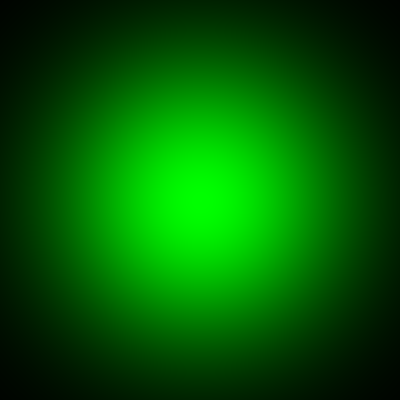

This runs for 500 iterations

Every iteration a network has 500 times to move on the map

Initial efficiency limit is 0.1 (but it increases by 0.0007 every 10 iterations)

Ignore last zero

In [63]:
f = open('/content/performance.txt', 'a')
f = open('/content/genes.txt', 'a')
function(0.1, 100, 500, 0)


ITERATION  0 RUN  0 TYPE  500
ITERATION  0 RUN  20 TYPE  500
ITERATION  0 RUN  40 TYPE  500
ITERATION  0 RUN  60 TYPE  500
ITERATION  0 RUN  80 TYPE  500
ITERATION  0 RUN  100 TYPE  500
ITERATION  0 RUN  120 TYPE  500
ITERATION  0 RUN  140 TYPE  500
ITERATION  0 RUN  160 TYPE  500
ITERATION  0 RUN  180 TYPE  500
ITERATION  0 RUN  200 TYPE  500
ITERATION  0 RUN  220 TYPE  500
ITERATION  0 RUN  240 TYPE  500
ITERATION  0 RUN  260 TYPE  500
ITERATION  0 RUN  280 TYPE  500
ITERATION  0 RUN  300 TYPE  500
ITERATION  0 RUN  320 TYPE  500
ITERATION  0 RUN  340 TYPE  500
ITERATION  0 RUN  360 TYPE  500
ITERATION  0 RUN  380 TYPE  500
ITERATION  0 RUN  400 TYPE  500
ITERATION  0 RUN  420 TYPE  500
ITERATION  0 RUN  440 TYPE  500
ITERATION  0 RUN  460 TYPE  500
ITERATION  0 RUN  480 TYPE  500


In [88]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.figure(figsize=(12,9))

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

In [89]:
def get_non_normalized_eff(strings):
    efficiencies=[]
    for n, line in enumerate(strings):
        if line.startswith('non-normalized efficiencies:') == True:
            l = line.strip('non-normalized efficiencies:')
            l = l.strip('\n')
            l = l.split(', ')
            l[-1] = l[-1].strip(',')
            efficiencies.append(l)
    return efficiencies

def get_normalized_eff(strings):
    efficiencies=[]
    for n, line in enumerate(strings):
        if line.startswith('efficiencies:') == True:
            l = line.strip('efficiencies:')
            l = l.strip('\n')
            l = l.split(', ')
            del l[-1]
            efficiencies.append(l)
    return efficiencies

def to_numerical(data):
    numerical = []
    for i in data:
        numerical.append([])
        for j in i:
            numerical[-1].append(float(j))
    return numerical

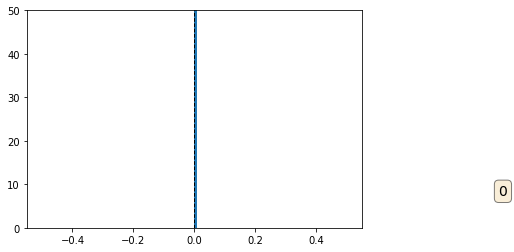

In [90]:
strings = []
for n, line in enumerate(open('/content/performance.txt')):
        strings.append(line.rstrip('\n'))


data = get_non_normalized_eff(strings)
data = to_numerical(data)

insertion = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def update_hist(num, data):
    plt.cla()
    plt.ylim(0, 50)

    plt.text(1, 10,  num, fontsize=14,
        verticalalignment='top', bbox=insertion)
    plt.axvline(sum(data[num])/len(data[num]), color='k', linestyle='dashed', linewidth=1)
    plt.hist(data[num], bins = 128)

fig = plt.figure()
plt.ylim(50)
plt.text(1, 10, str(0),fontsize=14,
        verticalalignment='top', bbox=insertion)
plt.axvline(sum(data[0])/len(data[0]), color='k', linestyle='dashed', linewidth=1)
hist = plt.hist(data[0], bins = 128)

anim = animation.FuncAnimation(fig, update_hist, len(data), fargs=(data, ),interval = 2 )
anim.save('/content/dynamics_animated.mp4')


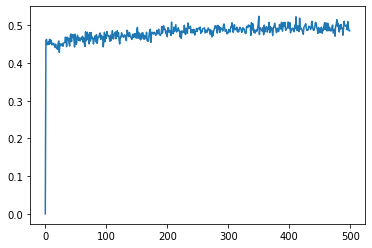

In [91]:
fig_mean = plt.figure()
mean = []
for i in range(len(data)):
    mean.append(sum(data[i])/len(data[i]))

plt.plot(mean)
plt.show()

Same as the previous one but uses *Fair* network factory

In [92]:
f = open('/content/performance.txt', 'a')
f = open('/content/genes.txt', 'a')
function(0.1, 100, 500, 0, 'fair')

ITERATION  0 RUN  0 TYPE  500
ITERATION  0 RUN  20 TYPE  500
ITERATION  0 RUN  40 TYPE  500
ITERATION  0 RUN  60 TYPE  500
ITERATION  0 RUN  80 TYPE  500
ITERATION  0 RUN  100 TYPE  500
ITERATION  0 RUN  120 TYPE  500
ITERATION  0 RUN  140 TYPE  500
ITERATION  0 RUN  160 TYPE  500
ITERATION  0 RUN  180 TYPE  500
ITERATION  0 RUN  200 TYPE  500
ITERATION  0 RUN  220 TYPE  500
ITERATION  0 RUN  240 TYPE  500
ITERATION  0 RUN  260 TYPE  500
ITERATION  0 RUN  280 TYPE  500
ITERATION  0 RUN  300 TYPE  500
ITERATION  0 RUN  320 TYPE  500
ITERATION  0 RUN  340 TYPE  500
ITERATION  0 RUN  360 TYPE  500
ITERATION  0 RUN  380 TYPE  500
ITERATION  0 RUN  400 TYPE  500
ITERATION  0 RUN  420 TYPE  500
ITERATION  0 RUN  440 TYPE  500
ITERATION  0 RUN  460 TYPE  500
ITERATION  0 RUN  480 TYPE  500


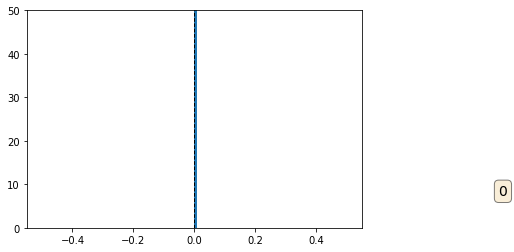

In [93]:
strings = []
for n, line in enumerate(open('/content/performance.txt')):
        strings.append(line.rstrip('\n'))


data = get_non_normalized_eff(strings)
data = to_numerical(data)

insertion = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def update_hist(num, data):
    plt.cla()
    plt.ylim(0, 50)

    plt.text(1, 10,  num, fontsize=14,
        verticalalignment='top', bbox=insertion)
    plt.axvline(sum(data[num])/len(data[num]), color='k', linestyle='dashed', linewidth=1)
    plt.hist(data[num], bins = 128)

fig = plt.figure()
plt.ylim(50)
plt.text(1, 10, str(0),fontsize=14,
        verticalalignment='top', bbox=insertion)
plt.axvline(sum(data[0])/len(data[0]), color='k', linestyle='dashed', linewidth=1)
hist = plt.hist(data[0], bins = 128)

anim = animation.FuncAnimation(fig, update_hist, len(data), fargs=(data, ),interval = 2 )
anim.save('/content/dynamics_animated_fair.mp4')


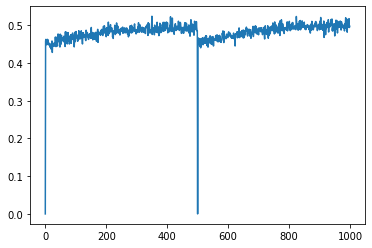

In [94]:
fig_mean = plt.figure()
mean = []
for i in range(len(data)):
    mean.append(sum(data[i])/len(data[i]))

plt.plot(mean )
plt.show()